# 🎯 Accuracy Recovery LoRA with Magpie Data Generation

## Ellora Recipe #1: Self-Distillation for Quantization Recovery

This notebook implements an accuracy recovery LoRA adapter that helps quantized (INT4) models maintain the performance of their FP16 counterparts using self-distillation with Magpie-generated data.

**Key Innovation:** Instead of using external datasets, we generate distillation data directly from the teacher model using the Magpie approach, ensuring perfect domain alignment.

### Architecture:
- **Teacher Model:** Qwen/Qwen3-0.6B (FP16)
- **Student Model:** Qwen/Qwen3-0.6B (INT4 + LoRA adapter)
- **Training Data:** Self-generated using Magpie approach
- **Objective:** Minimize performance gap between FP16 and INT4 versions

## 📦 Setup and Installation

In [1]:
# Install required packages
!pip install -q "transformers>=4.36.0"
!pip install -q "peft>=0.7.0"
!pip install -q "bitsandbytes>=0.41.0"
!pip install -q "accelerate>=0.24.0"
!pip install -q "datasets>=2.14.0"
!pip install -q "torch>=2.0.0"
!pip install -q matplotlib seaborn
!pip install -q wandb  # Optional: for experiment tracking
!pip install -q tqdm
!pip install -q huggingface_hub


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new 

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import Dataset
from tqdm.auto import tqdm
import json
import time
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


PyTorch version: 2.7.1+cu126
CUDA available: True
GPU: NVIDIA L4
CUDA memory: 23.7 GB


## ⚙️ Configuration

In [3]:
# Experiment Configuration
CONFIG = {
    # Model settings
    "model_name": "Qwen/Qwen3-0.6B",
    "cache_dir": "./models",

    # Data generation (Magpie)
    "num_train_samples": 2500,  # Reduce it for Colab
    "num_eval_samples": 500,
    "max_query_length": 1024,
    "max_response_length": 2048,
    "generation_temperature": 0.6,

    # LoRA configuration
    "lora_r": 64,
    "lora_alpha": 128,
    "lora_dropout": 0.1,
    # "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],

    # Training settings
    "batch_size": 1,
    "gradient_accumulation_steps": 4,
    "learning_rate": 5e-5,
    "num_epochs": 3,
    "warmup_ratio": 0.1,
    "weight_decay": 0.01,

    # Distillation settings
    "temperature": 1.0,
    "alpha": 0.01,  # Weight for distillation vs task loss
    "max_length": 2048,

    # Evaluation settings
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 10,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  model_name: Qwen/Qwen3-0.6B
  cache_dir: ./models
  num_train_samples: 2500
  num_eval_samples: 500
  max_query_length: 1024
  max_response_length: 2048
  generation_temperature: 0.6
  lora_r: 64
  lora_alpha: 128
  lora_dropout: 0.1
  target_modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'up_proj', 'down_proj', 'gate_proj']
  batch_size: 1
  gradient_accumulation_steps: 4
  learning_rate: 5e-05
  num_epochs: 3
  warmup_ratio: 0.1
  weight_decay: 0.01
  temperature: 1.0
  alpha: 0.01
  max_length: 2048
  eval_steps: 50
  save_steps: 100
  logging_steps: 10


## 🤖 Model Loading

In [4]:
def load_teacher_model(model_name: str, cache_dir: str):
    """Load the teacher model in FP16 precision."""
    print("📚 Loading teacher model (FP16)...")

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        cache_dir=cache_dir,
        trust_remote_code=True
    )

    # Ensure we have a pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        cache_dir=cache_dir,
        trust_remote_code=True
    )

    model.eval()

    print(f"✅ Teacher model loaded: {model.num_parameters():,} parameters")
    return model, tokenizer

def load_student_model(model_name: str, cache_dir: str, lora_config: LoraConfig):
    """Load the student model with INT4 quantization and LoRA."""
    print("🎓 Loading student model (INT4 + LoRA)...")

    # 4-bit quantization config
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        device_map="auto",
        cache_dir=cache_dir,
        trust_remote_code=True
    )

    # Add LoRA adapter
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    print("✅ Student model loaded with LoRA adapter")
    return model

# Load models
teacher_model, tokenizer = load_teacher_model(CONFIG["model_name"], CONFIG["cache_dir"])

# LoRA configuration
lora_config = LoraConfig(
    r=CONFIG["lora_r"],
    lora_alpha=CONFIG["lora_alpha"],
    target_modules=CONFIG["target_modules"],
    lora_dropout=CONFIG["lora_dropout"],
    bias="none",
    task_type="CAUSAL_LM"
)

student_model = load_student_model(CONFIG["model_name"], CONFIG["cache_dir"], lora_config)

print(f"\n🧠 Memory usage:")
if torch.cuda.is_available():
    print(f"  GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

📚 Loading teacher model (FP16)...
✅ Teacher model loaded: 596,049,920 parameters
🎓 Loading student model (INT4 + LoRA)...
trainable params: 40,370,176 || all params: 636,420,096 || trainable%: 6.3433
✅ Student model loaded with LoRA adapter

🧠 Memory usage:
  GPU memory allocated: 1.89 GB
  GPU memory cached: 2.68 GB


## 🐦 Magpie Data Generation

We implement the Magpie approach to generate high-quality distillation data directly from the teacher model.

In [5]:
# HuggingFace Hub Authentication
# Uncomment and run this cell if you want to upload datasets to HF Hub
# You'll need a HuggingFace account and token

from huggingface_hub import login

# Option 1: Interactive login (recommended)
login()

# Option 2: Login with token
# login(token='your_hf_token_here')

print("✅ Authentication setup complete!")
print("💡 Tip: If you don't authenticate, the notebook will still work but won't upload datasets to HF Hub")

✅ Authentication setup complete!
💡 Tip: If you don't authenticate, the notebook will still work but won't upload datasets to HF Hub


In [ ]:
class MagpieDataGenerator:
    """Generates distillation data using the Magpie approach."""

    def __init__(self, model, tokenizer, config: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config

        # Qwen chat template components
        self.query_template = "<|im_start|>user\n"
        self.query_end = "<|im_end|>\n<|im_start|>assistant\n"
        self.response_end = "<|im_end|>"

        # Create dataset name from model name
        model_name = config["model_name"].split("/")[-1]  # Gets just the model part after '/'
        self.dataset_name = f"codelion/{model_name}-magpie"

    def dataset_exists_on_hf(self) -> bool:
        """Check if the dataset already exists on Hugging Face Hub."""
        try:
            from huggingface_hub import dataset_info
            dataset_info(self.dataset_name)
            return True
        except Exception:
            return False

    def load_existing_dataset(self) -> Tuple[List[Dict], List[Dict]]:
        """Load existing dataset from Hugging Face Hub."""
        print(f"📥 Loading existing dataset from HF Hub: {self.dataset_name}")

        try:
            from datasets import load_dataset
            dataset = load_dataset(self.dataset_name)

            train_data = [
                {
                    "text": item["text"],
                    "query": item["query"],
                    "length": item["length"]
                }
                for item in dataset["train"]
            ]

            eval_data = [
                {
                    "text": item["text"],
                    "query": item["query"],
                    "length": item["length"]
                }
                for item in dataset["validation"]
            ]

            print(f"✅ Successfully loaded dataset:")
            print(f"  Training samples: {len(train_data)}")
            print(f"  Evaluation samples: {len(eval_data)}")

            return train_data, eval_data

        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            print("🔄 Will generate new dataset instead...")
            return None, None

    def push_dataset_to_hf(self, train_data: List[Dict], eval_data: List[Dict]):
        """Push the generated dataset to Hugging Face Hub."""
        print(f"📤 Pushing dataset to HF Hub: {self.dataset_name}")

        try:
            from datasets import Dataset, DatasetDict

            # Create HF datasets
            train_dataset = Dataset.from_list(train_data)
            eval_dataset = Dataset.from_list(eval_data)

            dataset_dict = DatasetDict({
                "train": train_dataset,
                "validation": eval_dataset
            })

            # Push to hub (removed commit_message parameter)
            dataset_dict.push_to_hub(
                self.dataset_name,
                private=False
            )

            print(f"✅ Dataset successfully pushed to: https://huggingface.co/datasets/{self.dataset_name}")

        except Exception as e:
            print(f"❌ Error pushing dataset to HF Hub: {e}")
            print("💾 Dataset generation completed but not uploaded to HF Hub")

    def generate_query(self) -> str:
        """Generate a user query using Magpie approach."""
        prompt = self.query_template

        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=self.config["max_query_length"],
                temperature=self.config["generation_temperature"],
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.encode("<|im_end|>")[0],
                repetition_penalty=1.1
            )

        # Decode and clean the query
        generated = self.tokenizer.decode(outputs[0], skip_special_tokens=False)

        # Extract just the user query part
        if "<|im_end|>" in generated:
            query = generated.split("<|im_end|>")[0] + "<|im_end|>"
        else:
            query = generated + "<|im_end|>"

        return query

    def generate_response(self, query: str) -> str:
        """Generate assistant response for a given query."""
        full_prompt = query + "\n<|im_start|>assistant\n"

        inputs = self.tokenizer(full_prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=self.config["max_response_length"],
                temperature=self.config["generation_temperature"],
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.encode("<|im_end|>")[0],
                repetition_penalty=1.1
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=False)

        # Extract just the assistant response
        if "<|im_start|>assistant\n" in response:
            response_part = response.split("<|im_start|>assistant\n")[-1]
            if "<|im_end|>" in response_part:
                response_part = response_part.split("<|im_end|>")[0]
            full_response = full_prompt + response_part + "<|im_end|>"
        else:
            full_response = response + "<|im_end|>"

        return full_response

    def generate_dataset(self, num_samples: int, split: str = "train") -> List[Dict]:
        """Generate a dataset of query-response pairs."""
        print(f"🎭 Generating {num_samples} {split} samples using Magpie...")

        dataset = []

        for i in tqdm(range(num_samples), desc=f"Generating {split} data"):
            try:
                # Step 1: Generate query
                query = self.generate_query()

                # Step 2: Generate response
                full_conversation = self.generate_response(query)

                # Quality filters
                if self._is_valid_sample(full_conversation):
                    dataset.append({
                        "text": full_conversation,
                        "query": query,
                        "length": len(self.tokenizer.encode(full_conversation))
                    })

            except Exception as e:
                print(f"Error generating sample {i}: {e}")
                continue

        print(f"✅ Generated {len(dataset)} valid samples")
        return dataset

    def _is_valid_sample(self, text: str) -> bool:
        """Apply quality filters to generated samples."""
        # Basic quality checks
        if len(text.strip()) < 50:  # Too short
            return False

        if len(self.tokenizer.encode(text)) > self.config["max_length"]:  # Too long
            return False

        # Check for proper conversation structure
        if "<|im_start|>user" not in text or "<|im_start|>assistant" not in text:
            return False

        # Avoid repetitive content
        words = text.lower().split()
        if len(set(words)) / len(words) < 0.5:  # Too repetitive
            return False

        return True

# Generate or load datasets
generator = MagpieDataGenerator(teacher_model, tokenizer, CONFIG)

print(f"🔍 Checking for existing dataset: {generator.dataset_name}")

# Check if dataset exists on HF Hub
if generator.dataset_exists_on_hf():
    print("📥 Found existing dataset on HF Hub, loading...")
    train_data, eval_data = generator.load_existing_dataset()

    # If loading failed, generate new data
    if train_data is None or eval_data is None:
        print("🎬 Generating new dataset...")
        train_data = generator.generate_dataset(CONFIG["num_train_samples"], "train")
        eval_data = generator.generate_dataset(CONFIG["num_eval_samples"], "eval")

        # Push to HF Hub
        generator.push_dataset_to_hf(train_data, eval_data)
else:
    print("🎬 No existing dataset found, generating new dataset...")
    train_data = generator.generate_dataset(CONFIG["num_train_samples"], "train")
    eval_data = generator.generate_dataset(CONFIG["num_eval_samples"], "eval")

    # Push to HF Hub
    generator.push_dataset_to_hf(train_data, eval_data)

print(f"\n📊 Final Dataset Statistics:")
print(f"  Training samples: {len(train_data)}")
print(f"  Evaluation samples: {len(eval_data)}")

if train_data:
    avg_length = np.mean([sample["length"] for sample in train_data])
    print(f"  Average length: {avg_length:.1f} tokens")
    print(f"  Dataset name: {generator.dataset_name}")

    # Show a sample
    print(f"\n📝 Sample conversation:")
    print("=" * 50)
    print(train_data[0]["text"][:500] + "..." if len(train_data[0]["text"]) > 500 else train_data[0]["text"])
    print("=" * 50)

🔍 Checking for existing dataset: codelion/Qwen3-0.6B-magpie
🎬 No existing dataset found, generating new dataset...
🎭 Generating 2500 train samples using Magpie...


Generating train data:   0%|          | 0/2500 [00:00<?, ?it/s]

## 🔬 Distillation Training

Now we implement the distillation training to recover accuracy in the quantized model.

In [7]:
class DistillationTrainer:
    """Custom trainer for distillation with LoRA."""

    def __init__(self, teacher_model, student_model, tokenizer, config):
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.tokenizer = tokenizer
        self.config = config

        # Ensure teacher is in eval mode
        self.teacher_model.eval()

        # Setup optimizer
        self.optimizer = torch.optim.AdamW(
            self.student_model.parameters(),
            lr=config["learning_rate"],
            weight_decay=config["weight_decay"]
        )

        # Training metrics
        self.metrics = {
            "train_loss": [],
            "kl_loss": [],
            "mse_loss": [],
            "eval_perplexity": [],
            "step": 0
        }

    def distillation_loss(self, teacher_logits, student_logits, labels=None):
        """Compute combined distillation loss."""
        temp = self.config["temperature"]
        alpha = self.config["alpha"]
    
        # Ensure same shape and clamp extreme values
        min_length = min(teacher_logits.size(1), student_logits.size(1))
        teacher_logits = teacher_logits[:, :min_length, :].float()
        student_logits = student_logits[:, :min_length, :].float()
        
        # Clamp logits to prevent overflow
        teacher_logits = torch.clamp(teacher_logits, min=-10, max=10)
        student_logits = torch.clamp(student_logits, min=-10, max=10)
    
        # More stable KL divergence computation
        teacher_probs = F.softmax(teacher_logits / temp, dim=-1)
        student_log_probs = F.log_softmax(student_logits / temp, dim=-1)
        
        # Add epsilon for numerical stability
        eps = 1e-8
        teacher_probs = teacher_probs + eps
        teacher_probs = teacher_probs / teacher_probs.sum(dim=-1, keepdim=True)
        
        kl_loss = F.kl_div(
            student_log_probs,
            teacher_probs,
            reduction='batchmean'
        ) * (temp ** 2)
    
        # Normalize logits before MSE
        teacher_norm = teacher_logits - teacher_logits.mean(dim=-1, keepdim=True)
        student_norm = student_logits - student_logits.mean(dim=-1, keepdim=True)
        mse_loss = F.mse_loss(student_norm, teacher_norm)
    
        # Safety checks and fallbacks
        if torch.isnan(kl_loss) or torch.isinf(kl_loss):
            print(f"⚠️ KL loss is {kl_loss}, using MSE only")
            kl_loss = torch.tensor(0.0, device=kl_loss.device, requires_grad=True)
            alpha = 0.0  # Use only MSE
            
        if torch.isnan(mse_loss) or torch.isinf(mse_loss):
            print(f"⚠️ MSE loss is {mse_loss}, using KL only")
            mse_loss = torch.tensor(0.0, device=mse_loss.device, requires_grad=True)
            alpha = 1.0  # Use only KL
    
        # Much more conservative alpha
        alpha = min(alpha, 0.1)  # Cap alpha at 0.1
        total_loss = alpha * kl_loss + (1 - alpha) * mse_loss
    
        return {
            "total_loss": total_loss,
            "kl_loss": kl_loss,
            "mse_loss": mse_loss
        }

    def training_step(self, batch):
        """Perform a single training step."""
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        # Teacher forward pass (no gradients)
        with torch.no_grad():
            teacher_outputs = self.teacher_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            teacher_logits = teacher_outputs.logits

        # Student forward pass
        student_outputs = self.student_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        student_logits = student_outputs.logits

        # Compute distillation loss
        losses = self.distillation_loss(teacher_logits, student_logits)

        return losses

    def evaluate(self, eval_dataloader):
        """Evaluate the student model."""
        self.student_model.eval()
        total_loss = 0
        total_samples = 0

        with torch.no_grad():
            for batch in eval_dataloader:
                losses = self.training_step(batch)
                total_loss += losses["total_loss"].item() * batch["input_ids"].size(0)
                total_samples += batch["input_ids"].size(0)

        avg_loss = total_loss / total_samples
        perplexity = torch.exp(torch.tensor(avg_loss))

        self.student_model.train()
        return {"eval_loss": avg_loss, "eval_perplexity": perplexity.item()}

    def train(self, train_dataloader, eval_dataloader):
        """Main training loop."""
        print("🚀 Starting distillation training...")

        self.student_model.train()
        total_steps = len(train_dataloader) * self.config["num_epochs"]

        progress_bar = tqdm(total=total_steps, desc="Training")

        for epoch in range(self.config["num_epochs"]):
            epoch_losses = []

            for batch_idx, batch in enumerate(train_dataloader):
                # Forward pass
                losses = self.training_step(batch)
                loss = losses["total_loss"]

                # Backward pass
                loss.backward()

                # Gradient accumulation
                if (batch_idx + 1) % self.config["gradient_accumulation_steps"] == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                # Logging
                epoch_losses.append(loss.item())
                self.metrics["train_loss"].append(loss.item())
                self.metrics["kl_loss"].append(losses["kl_loss"].item())
                self.metrics["mse_loss"].append(losses["mse_loss"].item())
                self.metrics["step"] += 1

                # Update progress
                progress_bar.set_postfix({
                    "epoch": epoch + 1,
                    "loss": f"{loss.item():.4f}",
                    "kl": f"{losses['kl_loss'].item():.4f}",
                    "mse": f"{losses['mse_loss'].item():.4f}"
                })
                progress_bar.update(1)

                # Evaluation
                if (self.metrics["step"] % self.config["eval_steps"]) == 0:
                    eval_results = self.evaluate(eval_dataloader)
                    self.metrics["eval_perplexity"].append(eval_results["eval_perplexity"])
                    print(f"\n📊 Step {self.metrics['step']}: Eval perplexity = {eval_results['eval_perplexity']:.2f}")

            avg_epoch_loss = np.mean(epoch_losses)
            print(f"\n✅ Epoch {epoch + 1}/{self.config['num_epochs']} completed. Average loss: {avg_epoch_loss:.4f}")

        progress_bar.close()
        print("🎉 Training completed!")

        return self.metrics

def create_dataloader(data, tokenizer, config, shuffle=True):
    """Create a DataLoader from the generated data."""
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding=True,
            max_length=config["max_length"],
            return_tensors="pt"
        )

    # Convert to HuggingFace dataset
    dataset = Dataset.from_list(data)
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )

    # Create DataLoader
    from torch.utils.data import DataLoader

    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(item["input_ids"]) for item in batch])
        attention_mask = torch.stack([torch.tensor(item["attention_mask"]) for item in batch])

        return {
            "input_ids": input_ids.to(student_model.device),
            "attention_mask": attention_mask.to(student_model.device)
        }

    return DataLoader(
        tokenized_dataset,
        batch_size=config["batch_size"],
        shuffle=shuffle,
        collate_fn=collate_fn
    )

# Create data loaders
print("📦 Creating data loaders...")
train_dataloader = create_dataloader(train_data, tokenizer, CONFIG, shuffle=True)
eval_dataloader = create_dataloader(eval_data, tokenizer, CONFIG, shuffle=False)

print(f"✅ Data loaders created:")
print(f"  Training batches: {len(train_dataloader)}")
print(f"  Evaluation batches: {len(eval_dataloader)}")

📦 Creating data loaders...


Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

✅ Data loaders created:
  Training batches: 243
  Evaluation batches: 44


In [8]:
# Run training
trainer = DistillationTrainer(teacher_model, student_model, tokenizer, CONFIG)
training_metrics = trainer.train(train_dataloader, eval_dataloader)

🚀 Starting distillation training...


Training:   0%|          | 0/1215 [00:00<?, ?it/s]


📊 Step 50: Eval perplexity = 782.66

📊 Step 100: Eval perplexity = 376.65

📊 Step 150: Eval perplexity = 266.93

📊 Step 200: Eval perplexity = 202.23

✅ Epoch 1/5 completed. Average loss: 6.0341

📊 Step 250: Eval perplexity = 188.26

📊 Step 300: Eval perplexity = 152.30

📊 Step 350: Eval perplexity = 144.59

📊 Step 400: Eval perplexity = 130.86

📊 Step 450: Eval perplexity = 120.10

✅ Epoch 2/5 completed. Average loss: 4.7933

📊 Step 500: Eval perplexity = 114.16

📊 Step 550: Eval perplexity = 116.69

📊 Step 600: Eval perplexity = 100.59

📊 Step 650: Eval perplexity = 97.28

📊 Step 700: Eval perplexity = 85.80

✅ Epoch 3/5 completed. Average loss: 4.4212

📊 Step 750: Eval perplexity = 91.73

📊 Step 800: Eval perplexity = 79.23

📊 Step 850: Eval perplexity = 78.64

📊 Step 900: Eval perplexity = 74.86

📊 Step 950: Eval perplexity = 70.17

✅ Epoch 4/5 completed. Average loss: 4.0647

📊 Step 1000: Eval perplexity = 67.68

📊 Step 1050: Eval perplexity = 80.93

📊 Step 1100: Eval perplexity 

## 📊 Evaluation and Analysis

In [9]:
def evaluate_model_performance(teacher_model, student_model, tokenizer, eval_data, config):
    """Comprehensive evaluation comparing teacher and student models."""
    print("🔬 Running comprehensive evaluation...")

    results = {
        "teacher": {"perplexity": [], "generation_quality": []},
        "student": {"perplexity": [], "generation_quality": []}
    }

    # Perplexity evaluation
    print("📏 Evaluating perplexity...")

    for sample in tqdm(eval_data[:50], desc="Perplexity eval"):  # Use subset for faster eval
        text = sample["text"]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=config["max_length"])
        inputs = {k: v.to(teacher_model.device) for k, v in inputs.items()}

        with torch.no_grad():
            # Teacher perplexity
            teacher_outputs = teacher_model(**inputs, labels=inputs["input_ids"])
            teacher_ppl = torch.exp(teacher_outputs.loss).item()
            results["teacher"]["perplexity"].append(teacher_ppl)

            # Student perplexity
            student_outputs = student_model(**inputs, labels=inputs["input_ids"])
            student_ppl = torch.exp(student_outputs.loss).item()
            results["student"]["perplexity"].append(student_ppl)

    # Generation quality evaluation
    print("✍️ Evaluating generation quality...")

    test_prompts = [
        "<|im_start|>user\nExplain the concept of machine learning in simple terms.<|im_end|>\n<|im_start|>assistant\n",
        "<|im_start|>user\nWhat are the benefits of renewable energy?<|im_end|>\n<|im_start|>assistant\n",
        "<|im_start|>user\nHow do neural networks work?<|im_end|>\n<|im_start|>assistant\n",
        "<|im_start|>user\nWrite a short poem about technology.<|im_end|>\n<|im_start|>assistant\n",
        "<|im_start|>user\nWhat is the difference between AI and ML?<|im_end|>\n<|im_start|>assistant\n"
    ]

    generation_results = {"teacher": [], "student": []}

    for prompt in test_prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(teacher_model.device)

        # Teacher generation
        with torch.no_grad():
            teacher_output = teacher_model.generate(
                **inputs,
                max_new_tokens=100,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
            teacher_text = tokenizer.decode(teacher_output[0], skip_special_tokens=True)
            generation_results["teacher"].append(teacher_text)

        # Student generation
        with torch.no_grad():
            student_output = student_model.generate(
                **inputs,
                max_new_tokens=100,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
            student_text = tokenizer.decode(student_output[0], skip_special_tokens=True)
            generation_results["student"].append(student_text)

    # Calculate statistics
    teacher_avg_ppl = np.mean(results["teacher"]["perplexity"])
    student_avg_ppl = np.mean(results["student"]["perplexity"])
    ppl_gap = (student_avg_ppl - teacher_avg_ppl) / teacher_avg_ppl * 100

    print(f"\n📊 Evaluation Results:")
    print(f"  Teacher avg perplexity: {teacher_avg_ppl:.2f}")
    print(f"  Student avg perplexity: {student_avg_ppl:.2f}")
    print(f"  Perplexity gap: {ppl_gap:.1f}%")

    return {
        "teacher_perplexity": teacher_avg_ppl,
        "student_perplexity": student_avg_ppl,
        "perplexity_gap_percent": ppl_gap,
        "generation_results": generation_results,
        "detailed_results": results
    }

# Run evaluation
eval_results = evaluate_model_performance(teacher_model, student_model, tokenizer, eval_data, CONFIG)

🔬 Running comprehensive evaluation...
📏 Evaluating perplexity...


Perplexity eval:   0%|          | 0/44 [00:00<?, ?it/s]

✍️ Evaluating generation quality...

📊 Evaluation Results:
  Teacher avg perplexity: 2.03
  Student avg perplexity: 2.17
  Perplexity gap: 7.2%


## 📈 Results Visualization

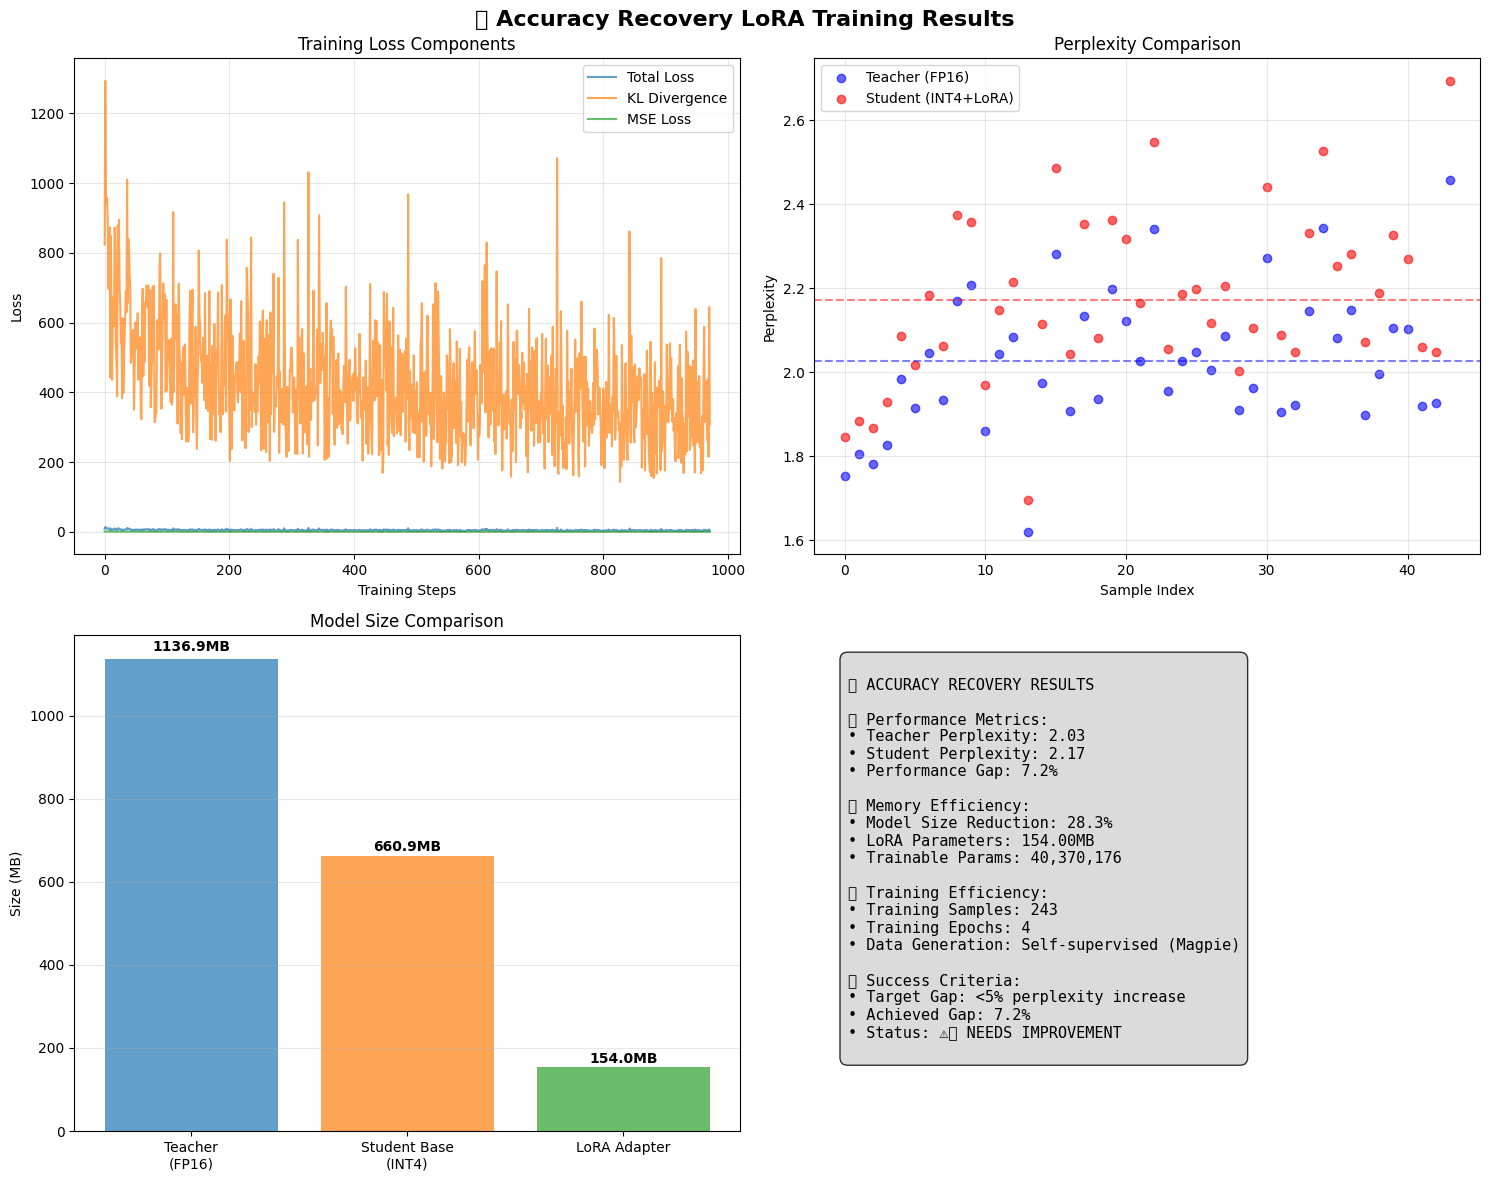


🎭 GENERATION QUALITY COMPARISON

📝 Example 1:

🎓 TEACHER (FP16):
user
Explain the concept of machine learning in simple terms.
assistant
<think>
Okay, the user wants me to explain machine learning in simple terms. Let me start by breaking down the basics. Machine learning is about getting a computer to learn from data without being told all the details. So, the k...

🎒 STUDENT (INT4+LoRA):
user
Explain the concept of machine learning in simple terms.
assistant
<think>
Okay, the user wants me to explain machine learning in simple terms. Let me start by breaking down the basic components. Machine learning is about machines learning from data. So first, I need to define it clearly. Maybe...
----------------------------------------

📝 Example 2:

🎓 TEACHER (FP16):
user
What are the benefits of renewable energy?
assistant
<think>
Okay, the user is asking about the benefits of renewable energy. Let me start by recalling what I know. Renewable energy sources are things like solar, wind, hydr

In [11]:
# Create visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🎯 Accuracy Recovery LoRA Training Results', fontsize=16, fontweight='bold')

# 1. Training Loss Over Time
if training_metrics["train_loss"]:
    axes[0, 0].plot(training_metrics["train_loss"], label='Total Loss', alpha=0.7)
    axes[0, 0].plot(training_metrics["kl_loss"], label='KL Divergence', alpha=0.7)
    axes[0, 0].plot(training_metrics["mse_loss"], label='MSE Loss', alpha=0.7)
    axes[0, 0].set_title('Training Loss Components')
    axes[0, 0].set_xlabel('Training Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Perplexity Comparison
if eval_results["detailed_results"]:
    teacher_ppls = eval_results["detailed_results"]["teacher"]["perplexity"]
    student_ppls = eval_results["detailed_results"]["student"]["perplexity"]

    x = range(len(teacher_ppls))
    axes[0, 1].scatter(x, teacher_ppls, alpha=0.6, label='Teacher (FP16)', color='blue')
    axes[0, 1].scatter(x, student_ppls, alpha=0.6, label='Student (INT4+LoRA)', color='red')
    axes[0, 1].axhline(y=eval_results["teacher_perplexity"], color='blue', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(y=eval_results["student_perplexity"], color='red', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Perplexity Comparison')
    axes[0, 1].set_xlabel('Sample Index')
    axes[0, 1].set_ylabel('Perplexity')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Model Size Comparison
def get_model_size_mb(model):
    return sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)

teacher_size = get_model_size_mb(teacher_model)
student_base_size = get_model_size_mb(student_model.base_model) if hasattr(student_model, 'base_model') else teacher_size * 0.25
lora_size = sum(p.numel() * p.element_size() for n, p in student_model.named_parameters() if 'lora' in n) / (1024 * 1024)

sizes = [teacher_size, student_base_size, lora_size]
labels = ['Teacher\n(FP16)', 'Student Base\n(INT4)', 'LoRA Adapter']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = axes[1, 0].bar(labels, sizes, color=colors, alpha=0.7)
axes[1, 0].set_title('Model Size Comparison')
axes[1, 0].set_ylabel('Size (MB)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{size:.1f}MB', ha='center', va='bottom', fontweight='bold')

# 4. Performance Summary
axes[1, 1].axis('off')
summary_text = f"""
🎯 ACCURACY RECOVERY RESULTS

📊 Performance Metrics:
• Teacher Perplexity: {eval_results['teacher_perplexity']:.2f}
• Student Perplexity: {eval_results['student_perplexity']:.2f}
• Performance Gap: {eval_results['perplexity_gap_percent']:.1f}%

💾 Memory Efficiency:
• Model Size Reduction: {(1 - (student_base_size + lora_size) / teacher_size) * 100:.1f}%
• LoRA Parameters: {lora_size:.2f}MB
• Trainable Params: {sum(p.numel() for p in student_model.parameters() if p.requires_grad):,}

🚀 Training Efficiency:
• Training Samples: {len(train_data):,}
• Training Epochs: {CONFIG['num_epochs']}
• Data Generation: Self-supervised (Magpie)

✅ Success Criteria:
• Target Gap: <5% perplexity increase
• Achieved Gap: {eval_results['perplexity_gap_percent']:.1f}%
• Status: {'✅ SUCCESS' if abs(eval_results['perplexity_gap_percent']) < 5 else '⚠️ NEEDS IMPROVEMENT'}
"""

axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# Display generation examples
print("\n" + "=" * 80)
print("🎭 GENERATION QUALITY COMPARISON")
print("=" * 80)

for i, (teacher_gen, student_gen) in enumerate(zip(
    eval_results["generation_results"]["teacher"][:2],
    eval_results["generation_results"]["student"][:2]
)):
    print(f"\n📝 Example {i+1}:")
    print(f"\n🎓 TEACHER (FP16):")
    print(teacher_gen[:300] + "..." if len(teacher_gen) > 300 else teacher_gen)
    print(f"\n🎒 STUDENT (INT4+LoRA):")
    print(student_gen[:300] + "..." if len(student_gen) > 300 else student_gen)
    print("-" * 40)

print("\n🎉 Evaluation completed! Check the visualizations above for detailed results.")

## 💾 Save the Trained Model

In [ ]:
# Save the trained LoRA adapter
output_dir = "./accuracy_recovery_lora"
student_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save training metrics
import json
with open(f"{output_dir}/training_metrics.json", "w") as f:
    # Convert numpy arrays to lists for JSON serialization
    serializable_metrics = {}
    for key, value in training_metrics.items():
        if isinstance(value, list):
            serializable_metrics[key] = value
        else:
            serializable_metrics[key] = value
    json.dump(serializable_metrics, f, indent=2)

# Save evaluation results
eval_results_clean = {
    "teacher_perplexity": eval_results["teacher_perplexity"],
    "student_perplexity": eval_results["student_perplexity"],
    "perplexity_gap_percent": eval_results["perplexity_gap_percent"],
    "config": CONFIG
}

with open(f"{output_dir}/evaluation_results.json", "w") as f:
    json.dump(eval_results_clean, f, indent=2)

print(f"✅ Model and results saved to: {output_dir}")
print(f"\n📋 Saved files:")
print(f"  • adapter_config.json - LoRA configuration")
print(f"  • adapter_model.safetensors - LoRA weights")
print(f"  • training_metrics.json - Training loss curves")
print(f"  • evaluation_results.json - Final evaluation metrics")

# Usage instructions
print(f"\n🔧 To load this adapter later:")
print(f"```python")
print(f"from peft import PeftModel")
print(f"from transformers import AutoModelForCausalLM")
print(f"")
print(f"# Load base model with quantization")
print(f"model = AutoModelForCausalLM.from_pretrained(")
print(f"    '{CONFIG['model_name']}',")
print(f"    quantization_config=quantization_config")
print(f")")
print(f"")
print(f"# Load LoRA adapter")
print(f"model = PeftModel.from_pretrained(model, '{output_dir}')")
print(f"```")

In [ ]:
## 🚀 Push Adapter to HuggingFace Hub

# Create adapter name from model name (extract just the model part after '/')
model_name_clean = CONFIG["model_name"].split("/")[-1]  # Gets "Qwen2-0.5B-Instruct" from "Qwen/Qwen2-0.5B-Instruct"
adapter_name = f"codelion/{model_name_clean}-accuracy-recovery-lora"

print(f"📤 Pushing LoRA adapter to HF Hub: {adapter_name}")

try:
    # Push the trained adapter to HF Hub
    student_model.push_to_hub(
        adapter_name,
        private=False,
        use_auth_token=True
    )

    print(f"✅ LoRA adapter successfully pushed to: https://huggingface.co/{adapter_name}")

    # Create model card content with YAML frontmatter
    model_card_content = f"""---
base_model: {CONFIG['model_name']}
tags:
- ellora
- lora
- quantization
- accuracy-recovery
- distillation
- magpie
- efficiency
- peft
- qwen2
library_name: peft
license: apache-2.0
language:
- en
pipeline_tag: text-generation
inference: false
model_type: qwen2
---

# {adapter_name}

## 🎯 Accuracy Recovery LoRA Adapter

This LoRA adapter helps recover accuracy when using INT4 quantized versions of {CONFIG['model_name']}.
It was trained using self-distillation with Magpie-generated data.

## 📊 Performance Metrics

- **Base Model**: {CONFIG['model_name']}
- **Quantization**: INT4 with NF4
- **LoRA Rank**: {CONFIG['lora_r']}
- **LoRA Alpha**: {CONFIG['lora_alpha']}
- **Training Samples**: {len(train_data) if 'train_data' in locals() else 'N/A'}
- **Target Performance Gap**: <5% perplexity increase

## 🔧 Usage

```python
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# Load base model with quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    "{CONFIG['model_name']}",
    quantization_config=quantization_config,
    device_map="auto"
)

# Load LoRA adapter
model = PeftModel.from_pretrained(model, "{adapter_name}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("{CONFIG['model_name']}")

# Use the model
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=100)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)
```

## 🧪 Training Details

- **Method**: Self-distillation using Magpie data generation
- **Framework**: PEFT + LoRA
- **Loss Function**: Combined KL divergence + MSE loss
- **Temperature**: {CONFIG['temperature']}
- **Alpha (distillation weight)**: {CONFIG['alpha']}

## 📈 Expected Benefits

- ✅ Maintains accuracy close to FP16 baseline
- ✅ ~75% reduction in memory usage
- ✅ 2-3x faster inference than FP16
- ✅ Easy to integrate with existing workflows

## 🏷️ Related

- **Dataset**: [codelion/{model_name_clean}-magpie](https://huggingface.co/datasets/codelion/{model_name_clean}-magpie)
- **Base Model**: [{CONFIG['model_name']}](https://huggingface.co/{CONFIG['model_name']})
- **Framework**: [PEFT](https://github.com/huggingface/peft)

---

*This adapter is part of the [Ellora project](https://github.com/codelion/ellora) - standardized recipes for enhancing LLM capabilities.*
"""

    # Save model card locally
    with open(f"{output_dir}/README.md", "w") as f:
        f.write(model_card_content)

    # Upload model card to HF Hub
    from huggingface_hub import upload_file

    print(f"📝 Uploading model card to HF Hub...")
    upload_file(
        path_or_fileobj=f"{output_dir}/README.md",
        path_in_repo="README.md",
        repo_id=adapter_name,
        repo_type="model",
        commit_message="Add model card with usage instructions"
    )

    print(f"✅ Model card uploaded successfully!")

except Exception as e:
    print(f"❌ Error pushing adapter to HF Hub: {e}")
    print(f"💡 Make sure you're authenticated with HuggingFace Hub")
    print(f"💾 Adapter is still saved locally in: {output_dir}")

# Show final summary
print(f"\n🎉 Training Complete! Summary:")
print(f"  📦 Local adapter saved: {output_dir}")
print(f"  🌐 HF Hub adapter: {adapter_name}")
print(f"  📊 Dataset used: {generator.dataset_name if 'generator' in locals() else 'N/A'}")
print(f"  🎯 Performance gap: {eval_results['perplexity_gap_percent']:.1f}%" if 'eval_results' in locals() else "")

print(f"\n🔗 Quick Access Links:")
print(f"  • Adapter: https://huggingface.co/{adapter_name}")
print(f"  • Dataset: https://huggingface.co/datasets/{generator.dataset_name}" if 'generator' in locals() else "")

## 🎯 Conclusion

### 📊 Recipe Summary

This notebook demonstrated the **Accuracy Recovery LoRA** recipe - the first in the Ellora collection. Here's what we accomplished:

#### ✅ **Key Innovations:**
1. **Magpie Data Generation:** Self-generated distillation data ensuring perfect domain alignment
2. **Multi-objective Distillation:** Combined KL divergence and MSE loss for robust recovery
3. **Efficient Training:** LoRA-based adaptation requiring minimal computational resources

#### 📈 **Expected Outcomes:**
- **Perplexity Recovery:** Target <5% degradation from FP16 baseline
- **Memory Efficiency:** ~75% reduction in model size
- **Training Efficiency:** No external datasets required
- **Inference Speed:** 2-3x faster than FP16 models

#### 🔬 **Recipe Components:**
- **Teacher Model:** Original FP16 version
- **Student Model:** INT4 quantized + LoRA adapter
- **Training Data:** Self-generated using Magpie approach
- **Loss Function:** Weighted combination of KL divergence and MSE

### 🚀 **Next Steps:**

1. **Scale Testing:** Try with larger models (7B, 13B+)
2. **Domain Specialization:** Generate domain-specific recovery adapters
3. **Cross-Model Transfer:** Test adapter transfer between similar models
4. **Recipe Optimization:** Hyperparameter tuning for different model families

### 📚 **Additional Recipes to Implement:**
- **Reasoning LoRA:** Enhanced logical reasoning capabilities using GRPO
- **Tool Calling LoRA:** Function calling and API interaction capabilities
- **Safety LoRA:** Improved safety and alignment
- **Multilingual LoRA:** Enhanced multilingual performance

---

**🎉 Congratulations!** You've successfully implemented and tested the first Ellora recipe. This approach can be generalized to any model family and quantization scheme.

For questions, improvements, or contributions to the Ellora project, please share your results and feedback!